In [70]:
import numpy as np
import scipy.sparse as sparse
from os import listdir
import matplotlib.pyplot as plt

In [195]:


#chroms = [str(x) for x in range(1, 23)]
chroms = ['X', 'Y']
#data_dir = '../split_gen_ihart'
data_dir = '../split_gen_spark'
ped_file = '../data/spark.ped'

# read samples
sample_file = '%s/chr.%s.gen.samples.txt' % (data_dir, chroms[0])
with open(sample_file, 'r') as f:
    sample_id_to_index = dict([(line.strip(), i) for i, line in enumerate(f)])

# read family structure
parents = set()
children = set()
mom_dad_pairs = list()
with open(ped_file, 'r') as f:
    for line in f:
        fam_id, ind_id, dad_id, mom_id, sex, disease_status = line.strip().split('\t')[:6]
        # sex: 1=male, 2=female
        # disease status: 1=unaffected, 2=affected
        if dad_id != '0' and dad_id in sample_id_to_index:
            parents.add(dad_id)
        if mom_id != '0' and mom_id in sample_id_to_index:
            parents.add(mom_id)
        if dad_id != '0' and dad_id in sample_id_to_index and mom_id != '0' and mom_id in sample_id_to_index:
            mom_dad_pairs.append((sample_id_to_index[mom_id], sample_id_to_index[dad_id]))
        if (dad_id != '0' or mom_id != '0') and ind_id in sample_id_to_index:
            children.add(ind_id)
        
# only interested in children, not parents
samples_of_interest = sorted(children | parents)
indices = [sample_id_to_index[s] for s in samples_of_interest]
print('Individuals of interest:', len(indices))

all_gen_data = []
all_positions = []
for chrom in chroms:
    print(chrom)
    
    # load genotypes
    gen_files = sorted([f for f in listdir(data_dir) if ('chr.%s.' % chrom) in f and 'gen.npz' in f])

    # pull snp positions
    pos_data = np.load('%s/chr.%s.gen.coordinates.npy' % (data_dir, chrom))
    is_snp = pos_data[:, 2].astype(bool)
    is_pass = pos_data[:, 3].astype(bool)
    #is_pass = np.ones(is_snp.shape, dtype=bool)
    snp_positions = pos_data[:, 1]
    print('Sites pulled from vcf:', snp_positions.shape[0])

    # pull PASS (from GATK)
    #is_pass = np.load('%s/chr.%s.pass.npy' % (data_dir, chrom))

    # Pull data together
    A = sparse.hstack([sparse.load_npz('%s/%s' % (data_dir, gen_file)) for gen_file in gen_files])

    # only look at snps that PASS GATK filter
    A = A[:, is_snp & is_pass]
    snp_positions = snp_positions[is_snp & is_pass]
    print('Removed %d sites that are not bi-allelic SNPs' % np.sum(~is_snp))
    print('Removed %d sites that do not pass GATK' % np.sum(is_snp & ~is_pass))

    # sparse to dense
    A = A.A

    # filter out sites with too many missing values
    missing_cutoff = 0.01
    lots_of_missing_indices = np.sum(A<0, axis=0) > 0.01*len(indices)
    #A = A[:, ~lots_of_missing_indices]
    #snp_positions = snp_positions[~lots_of_missing_indices]
    print('Removed %d sites with >%0.3f missing' % (np.sum(lots_of_missing_indices), missing_cutoff))

    # remove sites where everyone is homref or missing
    has_variants = np.any(A>0, axis=0)
    #A = A[:, has_variants]
    #snp_positions = snp_positions[has_variants]
    print('Removed %d sites where everyone is hom-ref' % np.sum(~has_variants))

    # remaining missing -> hom ref
    #print('Changed %d calls from missing (-1) to hom-ref (0)' % np.sum(A<0))
    #A[A<0] = 0

    print('Final matrix', A.shape, snp_positions.shape)
    
    all_gen_data.append(A)
    all_positions.append(snp_positions)


Individuals of interest: 13249
X
Sites pulled from vcf: 16790
Removed 621 sites that are not bi-allelic SNPs
Removed 2624 sites that do not pass GATK
Removed 6085 sites with >0.010 missing
Removed 451 sites where everyone is hom-ref
Final matrix (13249, 13545) (13545,)
Y
Sites pulled from vcf: 1454
Removed 52 sites that are not bi-allelic SNPs
Removed 51 sites that do not pass GATK
Removed 1163 sites with >0.010 missing
Removed 127 sites where everyone is hom-ref
Final matrix (13249, 1351) (1351,)


In [169]:
# pull male/female indices
with open('%s/chr.%s.gen.samples.txt' % (data_dir, chrom), 'r') as f:
    sample_ids = [x.strip() for x in f]

sample_id_to_sex = dict()
# Sex (1=male; 2=female; other=unknown)
with open(ped_file, 'r') as f:
    for line in f:
        pieces = line.strip().split('\t')
        if len(pieces) >= 6:
            fam_id, sample_id, f_id, m_id, sex, disease_status = pieces[0:6]
            sample_id_to_sex[sample_id] = sex
            
is_male = np.array([x in sample_id_to_sex and sample_id_to_sex[x]=='1' for x in sample_ids], dtype=bool)
is_female = np.array([x in sample_id_to_sex and sample_id_to_sex[x]=='2' for x in sample_ids], dtype=bool)
print(np.sum(is_male), np.sum(is_female))

819 780


In [170]:
is_parent = np.array([x in parents for x in sample_ids], dtype=bool)
is_child = np.array([x in children for x in sample_ids], dtype=bool)

is_mom = is_parent & is_female
is_dad = is_parent & is_male

print(np.sum(is_parent), np.sum(is_child))
print(np.sum(is_mom), np.sum(is_dad))

674 944
348 316


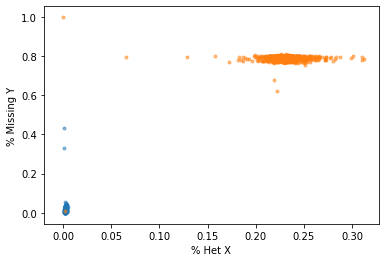

In [171]:
num_het_X = np.sum(all_gen_data[0]==1, axis=1)/all_gen_data[0].shape[1]
num_missing_Y = np.sum(all_gen_data[1]<0, axis=1)/all_gen_data[1].shape[1]

plt.scatter(num_het_X[is_male], num_missing_Y[is_male], alpha=0.5, marker='.')
plt.scatter(num_het_X[is_female], num_missing_Y[is_female], alpha=0.5, marker='.')
plt.xlabel('% Het X')
plt.ylabel('% Missing Y')
#plt.xlim([-.1, 1])
#plt.ylim([-.1, 1])

plt.show()

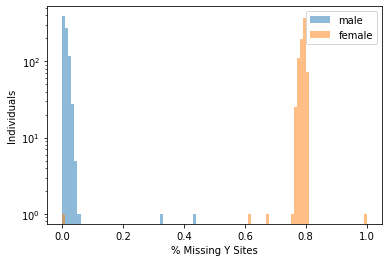

In [172]:
plt.hist(num_missing_Y[is_male], log=True, bins=np.arange(0, 1.01, 0.01), alpha=0.5, label='male')
#plt.hist(num_missing_Y[is_dad], log=True, bins=np.arange(0, 1.01, 0.01), alpha=0.5, label='dad')
#plt.hist(num_missing_Y[is_child & is_male], log=True, bins=np.arange(0, 1.01, 0.01), alpha=0.5, label='son')

plt.hist(num_missing_Y[is_female], log=True, bins=np.arange(0, 1.01, 0.01), alpha=0.5, label='female')
#plt.hist(num_missing_Y[is_mom], log=True, bins=np.arange(0, 1.01, 0.01), alpha=0.5, label='mom')
#plt.hist(num_missing_Y[is_child & is_female], log=True, bins=np.arange(0, 1.01, 0.01), alpha=0.5, label='daughter')

plt.legend()
plt.xlabel('% Missing Y Sites')
plt.ylabel('Individuals')
plt.show()

In [189]:
homalt_m = np.sum(all_gen_data[0][is_male, :]==2, axis=0)
het_m = np.sum(all_gen_data[0][is_male, :]==1, axis=0)
miss_m = np.sum(all_gen_data[0][is_male, :]<0, axis=0)

homalt_f = np.sum(all_gen_data[0][is_female, :]==2, axis=0)
het_f = np.sum(all_gen_data[0][is_female, :]==1, axis=0)
miss_f = np.sum(all_gen_data[0][is_female, :]<0, axis=0)

af_m = (2*homalt_m + het_m)/(2*np.sum(is_male) - 2*miss_m)
af_f = (2*homalt_f + het_f)/(2*np.sum(is_female) - 2*miss_f)

percent_miss_m = miss_m/np.sum(is_male)
percent_miss_f = miss_f/np.sum(is_female)

pass_X = percent_miss_f < 0.10 

//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log10
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:21: RuntimeWarning: divide by zero encountered in log10


y cutoff 0.257020757020757
0.9973031283710896


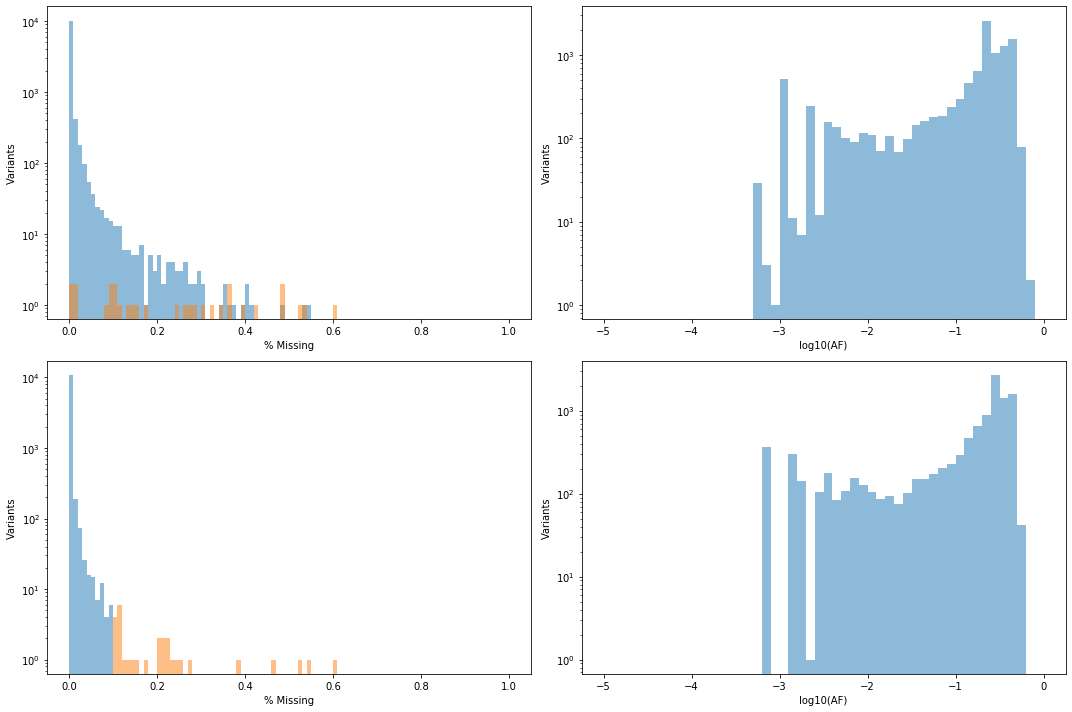

In [191]:
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
plt.hist(percent_miss_m[pass_X], log=True, bins=np.arange(0, 1.01, 0.01), alpha=0.5)
plt.hist(percent_miss_m[~pass_X], log=True, bins=np.arange(0, 1.01, 0.01), alpha=0.5)
plt.xlabel('% Missing')
plt.ylabel('Variants')

plt.subplot(2, 2, 2)
plt.hist(np.log10(af_m), log=True, alpha=0.5, bins=np.arange(-5, 0.1, 0.1))
plt.xlabel('log10(AF)')
plt.ylabel('Variants')

plt.subplot(2, 2, 3)
plt.hist(percent_miss_f[pass_X], log=True, bins=np.arange(0, 1.01, 0.01), alpha=0.5)
plt.hist(percent_miss_f[~pass_X], log=True, bins=np.arange(0, 1.01, 0.01), alpha=0.5)
plt.xlabel('% Missing')
plt.ylabel('Variants')

plt.subplot(2, 2, 4)
plt.hist(np.log10(af_f), log=True, alpha=0.5, bins=np.arange(-5, 0.1, 0.1))
plt.xlabel('log10(AF)')
plt.ylabel('Variants')

Y_cutoff = np.quantile(percent_miss_m[~pass_X], 0.5)
print('y cutoff', Y_cutoff)
print(np.sum(pass_X)/pass_X.shape[0])

plt.tight_layout()
plt.show()

In [192]:
homalt_m = np.sum(all_gen_data[1][is_male, :]==2, axis=0)
het_m = np.sum(all_gen_data[1][is_male, :]==1, axis=0)
miss_m = np.sum(all_gen_data[1][is_male, :]<0, axis=0)

homalt_f = np.sum(all_gen_data[1][is_female, :]==2, axis=0)
het_f = np.sum(all_gen_data[1][is_female, :]==1, axis=0)
miss_f = np.sum(all_gen_data[1][is_female, :]<0, axis=0)

af_m = (2*homalt_m + het_m)/(2*np.sum(is_male) - 2*miss_m)
af_f = (2*homalt_f + het_f)/(2*np.sum(is_female) - 2*miss_f)

percent_miss_m = miss_m/np.sum(is_male)
percent_miss_f = miss_f/np.sum(is_female)

//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log10
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:20: RuntimeWarning: divide by zero encountered in log10


0.983969465648855


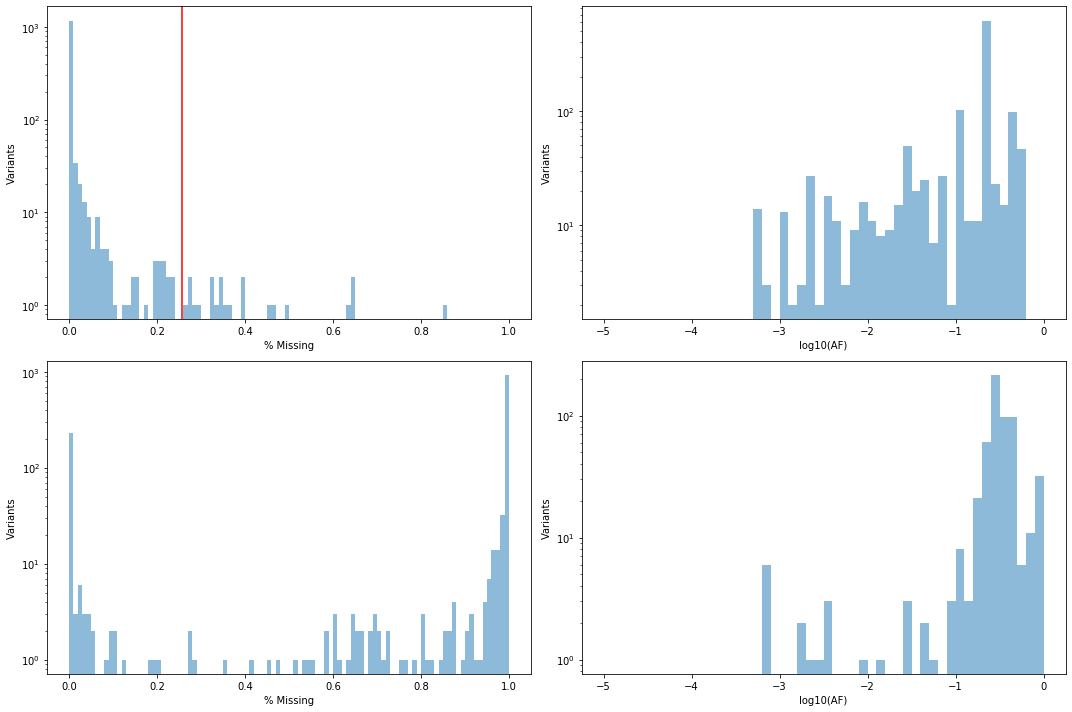

In [194]:
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
plt.hist(percent_miss_m, log=True, bins=np.arange(0, 1.01, 0.01), alpha=0.5)
plt.xlabel('% Missing')
plt.ylabel('Variants')
plt.axvline(Y_cutoff, color='red')

plt.subplot(2, 2, 2)
plt.hist(np.log10(af_m), log=True, alpha=0.5, bins=np.arange(-5, 0.1, 0.1))
plt.xlabel('log10(AF)')
plt.ylabel('Variants')

plt.subplot(2, 2, 3)
plt.hist(percent_miss_f, log=True, bins=np.arange(0, 1.01, 0.01), alpha=0.5)
plt.xlabel('% Missing')
plt.ylabel('Variants')

plt.subplot(2, 2, 4)
plt.hist(np.log10(af_f), log=True, alpha=0.5, bins=np.arange(-5, 0.1, 0.1))
plt.xlabel('log10(AF)')
plt.ylabel('Variants')

pass_Y = (percent_miss_m < Y_cutoff)
print(np.sum(pass_Y)/pass_Y.shape[0])

plt.tight_layout()
plt.show()

In [14]:
with open('../data/OMNI2.5_pruned_positions.txt', 'w+') as outf:
    outf.write('# rsid\tchromosome\tposition\n')
    for chrom in [str(x) for x in range(1, 23)]:
        with open('../../PrunediHART/%s.pruned.bim' % chrom) as f:
            for line in f:
                pieces = line.strip().split('\t')
                outf.write('.\t%s\t%s\n' % (chrom, pieces[3]))
    

In [29]:
gen_files = sorted([f for f in listdir(data_dir) if ('chr.%s.' % chrom) in f and 'gen.npz' in f])

# Pull data together
A = sparse.hstack([sparse.load_npz('%s/%s' % (data_dir, gen_file)) for gen_file in gen_files])
A = A[:, is_snp]

# AF filter
homalt = (A==2).sum(axis=0).A.flatten()
het = (A==1).sum(axis=0).A.flatten()
miss = (A<0).sum(axis=0).A.flatten()
af = (2*homalt + het)/(2*gen_data.shape[0] - 2*miss)

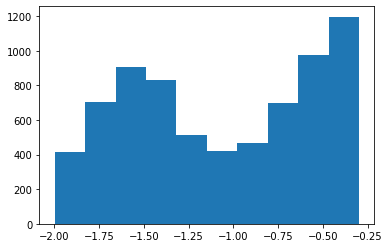

In [32]:
plt.hist(np.log10(af[af>0.01]))
plt.show()

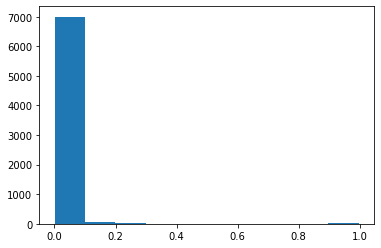

In [34]:
plt.hist(miss[af>0.01]/A.shape[0])
plt.show()

In [42]:
print(A.shape)

(13249, 13725)
